**Exercise:** In the 2010-11 National Hockey League (NHL) Finals, my beloved Boston
Bruins played a best-of-seven championship series against the despised
Vancouver Canucks.  Boston lost the first two games 0-1 and 2-3, then
won the next two games 8-1 and 4-0.  At this point in the series, what
is the probability that Boston will win the next game, and what is
their probability of winning the championship?

To choose a prior distribution, I got some statistics from
http://www.nhl.com, specifically the average goals per game
for each team in the 2010-11 season.  The distribution is well modeled by a gamma distribution with mean 2.8.

In what ways do you think the outcome of these games might violate the assumptions of the Poisson model?  How would these violations affect your predictions?

***
https://en.wikipedia.org/wiki/2011_Stanley_Cup_playoffs#Stanley_Cup_Finals

Spoiler, the next three matches were:
* 0 - 1 for Vancouver  
* 5 - 2 for Boston  
* 4 - 0 for Boston

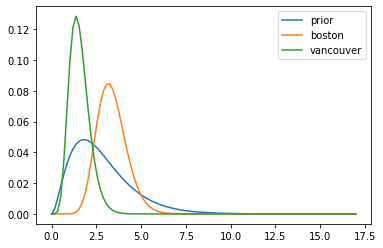

In [1]:
# Solution goes here
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gamma, poisson

# create the common prior for both teams.
goals = 17  # chosen 17 as it will mean that the mean would be 2.8
lbd_values = np.linspace(0, goals, 101)
prior = gamma(2.8).pdf(lbd_values)
prior /= prior.sum()
np.sum(lbd_values * prior)  # 2.8 mean

# Create likelihoods
matches = ((0, 1), (2, 3), (8, 1), (4, 0))
pb = [poisson(lbd_values).pmf(match[0]) for match in matches]
pb = np.array(pb).prod(axis=0)
theta_b = prior.copy()
theta_b *= pb
theta_b /= theta_b.sum()

pc = [poisson(lbd_values).pmf(match[1]) for match in matches]
pc = np.array(pc).prod(axis=0)
theta_c = prior.copy()
theta_c *= pc
theta_c /= theta_c.sum()

# plot above to see how it looks
sns.lineplot(x=lbd_values, y=prior, label="prior");
sns.lineplot(x=lbd_values, y=theta_b, label="boston");
sns.lineplot(x=lbd_values, y=theta_c, label="vancouver");

(0.771375106613984, 0.2286236382220115)

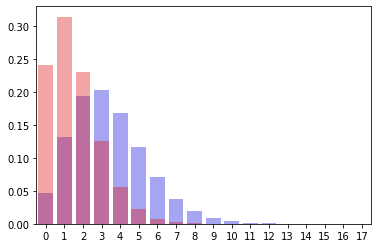

In [2]:
# Create an array for the posterior predictive for each team
goal_range = np.arange(goals + 1)
initial_predictive = pd.DataFrame([poisson(lbd).pmf(goal_range) for lbd in lbd_values])

boston_predictive = initial_predictive.copy()
boston_predictive = (boston_predictive.T * theta_b).sum(axis=1)

vancouver_predictive = initial_predictive.copy()
vancouver_predictive = (vancouver_predictive.T * theta_c).sum(axis=1)

# let's see how they look
sns.barplot(x=goal_range, y=boston_predictive, alpha=.4, color="blue");
sns.barplot(x=goal_range, y=vancouver_predictive, alpha=.4, color="red");

# Compute the cartesian product of the matches
gx, gy = np.meshgrid(goal_range, goal_range)
boston_wins = (gx - gy) > 0
vancouver_wins = (gx - gy) < 0
tie = (gx - gy) == 0

vx, vy = np.meshgrid(boston_predictive, vancouver_predictive)
joint_p = vx * vy

# let's give each a 50% chance of breaking the tie.
prob_boston_wins = joint_p[boston_wins].sum() + joint_p[tie].sum() / 2
prob_vancouver_wins = joint_p[vancouver_wins].sum() + joint_p[tie].sum() / 2

prob_boston_wins, prob_vancouver_wins

In [22]:
# Next three matches combinations (doing this through a binomial dist like in the solution
# like the solution is way more elegant)
b, v = prob_boston_wins, prob_vancouver_wins
bl, vl = "boston", "vancouver"
next_three = pd.DataFrame({
    "fifth": [b, b, v, v, v, b],
    "sixth": [b, v, b, v, b, v],
    "seventh": [np.nan, b, b, np.nan, v, v],
    "winner": [bl, bl, bl, vl, vl, vl]
})

(next_three[next_three.winner == "boston"].prod(axis=1).sum(),
next_three[next_three.winner == "vancouver"].prod(axis=1).sum())

(0.8670906261058524, 0.1329064208598641)